### 1.  Download the dataset

In [ ]:
!pip install opendatasets --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/aryan57/new-dataset-3'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aryan57
Your Kaggle Key: ··········


100%|██████████| 1.06G/1.06G [01:02<00:00, 18.2MB/s]


### 2.  Load the dataset

In [ ]:
labels_map = {
    0:	"fallen-tree" ,
    1:	"road" ,
    2:	"garbage" ,
    3:	"pothole"
}

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import ToTensor,Lambda
import matplotlib.pyplot as plt
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        # return image, label, self.img_labels.iloc[idx, 0]
        return image, label

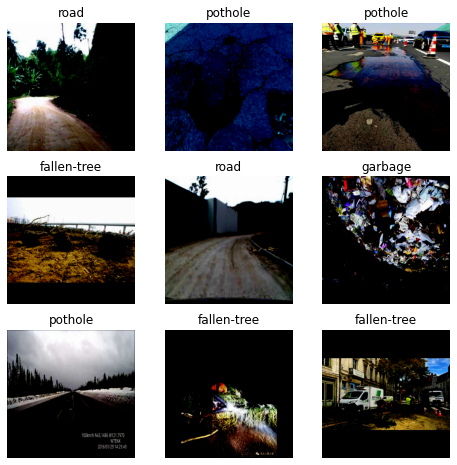

In [ ]:
train_csv_file_path = './new-dataset-3/new-dataset-3/train.csv'
train_img_path = './new-dataset-3/new-dataset-3/train'
test_csv_file_path = './new-dataset-3/new-dataset-3/test.csv'
test_img_path = './new-dataset-3/new-dataset-3/test'

transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

training_data = CustomImageDataset(train_csv_file_path,train_img_path,transform,target_transform=None)
test_data = CustomImageDataset(test_csv_file_path,test_img_path,transform,target_transform=None)

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    # PIL Image H*W*C
    # Pytorch Image C*H*W
    # plt expects PIL image, so converting Pytorch image to PIL image
    plt.imshow(img.permute(1,2,0))
plt.show()

Feature batch shape: torch.Size([4, 3, 640, 640])
Labels batch shape: torch.Size([4])


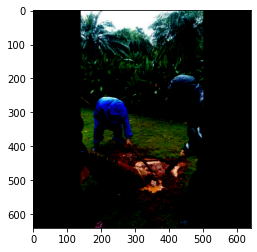

Label: 0


In [ ]:
from torch.utils.data import DataLoader

batch_size = 4
num_workers = 2
train_dataloader = DataLoader(training_data, batch_size=batch_size,num_workers=num_workers, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size,num_workers=num_workers, shuffle=True)

# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze() # sqeeze removes 1 dimensions
label = train_labels[0]
plt.imshow(img.permute(1,2,0))
plt.show()
print(f"Label: {label}")

### 2. Define CNN

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

# Define a convolution neural network
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)

        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)

        self.pool = nn.MaxPool2d(2,2)

        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)

        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
     
        self.fc1 = nn.Linear(24*314*314, 4)

        # 24*314*314 => C*H*W => C = channel
        # 4 is no of classes

    def forward(self, input):
        # print(input.shape)
        output = F.relu(self.bn1(self.conv1(input)))      
        output = F.relu(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = F.relu(self.bn4(self.conv4(output)))     
        output = F.relu(self.bn5(self.conv5(output)))     
        # print(output.shape)
        """
        we got 4D matrix from batch of images
        4x24x10x10 this is a 4D matrix
        => output.view(-1, 24*10*10)
        => 4x2400 
        we converted this to 2D matrix

        Now linear will change as g((W^T)*x+b)
        g => ReLU
        x => 4x2400
        W => 2400x8
        W^T => 8x2400
        b => 8x1

        each x is actually 2400x1 
        4 is the batch size. So,
        (W^T)*x will be 8x1

        and b is 8x1

        both will be added

        and the result be resulted in 
        4x8 as 4 is the batch size
        """
        output = output.view(-1, 24*314*314)
        #output = output.view(24*10*10,-1)
        output = self.fc1(output)

        return output

# Instantiate a neural network model 
model = Network()

### 3. Define Loss function and optimizer

In [ ]:
from torch.optim import Adam
 
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

### 4. Train the network

In [ ]:
# !pip install tqdm

In [ ]:
from torch.autograd import Variable
from tqdm import tqdm

# Function to save the model
def saveModel():
    path = "./myFirstModel.pth"
    torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy():
    print(model.training)
    
    model.eval()
    accuracy = 0.0
    total = 0.0

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    
    with torch.no_grad():
        for data in tqdm(test_dataloader,position=0,leave=True,total=len(test_dataloader)):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    print(model.training)
    return(accuracy)


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):
    
    best_accuracy = 0.0

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        model.train(True)
        print("in epoch "+str(epoch)+" "+str(model.training))
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in tqdm(enumerate(train_dataloader, 0),position=0,leave=True,total=len(train_dataloader)):
            
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 500 images
            running_loss += loss.item()     # extract the loss value
            if i % 500 == 499:    
                # print every 500 (twice per epoch) 
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 500))
                # zero the loss
                running_loss = 0.0

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy

### 5. Test the network on the test data



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show the images
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Function to test the model with a batch of images and show the labels predictions
def testBatch():
    # get batch of images from the test DataLoader  
    images, labels = next(iter(test_dataloader))

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images))
    
    # Show the real labels on the screen 
    print('Real labels: ', ' '.join('%5s' % labels_map[int(labels[j])] 
                               for j in range(batch_size)))
  
    # Let's see what if the model identifiers the  labels of those example
    outputs = model(images)
    # print(type(outputs))
    # print(type(outputs.data))
    
    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)
    # Let's show the predicted labels on the screen to compare with the real ones
    print('Predicted: ', ' '.join('%5s' % labels_map[int(predicted[j])] 
                              for j in range(batch_size)))
    
def testAllAgain():
    # get batch of images from the test DataLoader
    model.eval()  
    accuracy = 0.0
    total = 0.0

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    with torch.no_grad():
        for data in tqdm(train_dataloader,position=0,leave=True,total=len(train_dataloader)):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    print(accuracy,total,(100 * accuracy / total))

Finished Training


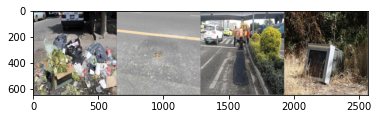

Real labels:  garbage pothole pothole garbage
Predicted:  garbage pothole garbage garbage


In [ ]:
# Let's build our model

train(5)
print('Finished Training')

# Test which classes performed well
# testModelAccuracy()

# Let's load the model we just created and test the accuracy per label
model = Network()
path = "./myFirstModel.pth"
model.load_state_dict(torch.load(path))
model.eval()
# Test with batch of images
testBatch()


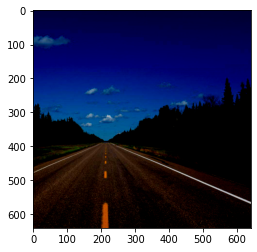

torch.Size([3, 640, 640])
torch.Size([4, 3, 640, 640])
tensor([[-4.3474,  5.7794,  1.1729, -4.4825],
        [-4.3474,  5.7794,  1.1729, -4.4825],
        [-4.3474,  5.7794,  1.1729, -4.4825],
        [-4.3474,  5.7794,  1.1729, -4.4825]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Predicted:  road


In [ ]:
img_path = "road3.jpg"
image = Image.open(img_path)
transform = transforms.Compose([
        transforms.Resize(640),
        transforms.RandomCrop(640),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
image = transform(image)
# image = image / 2 + 0.5     # unnormalize
npimg = image.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()
images = image[None]
lst = [images,images,images,images]
images = torch.cat(lst)
print(image.shape)
print(images.shape)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
images = images.to(device)
model = model.to(device)
# print(images.shape)
# model.eval()
outputs = model(images)
print(outputs)
_, predicted = torch.max(outputs, 1)
print('Predicted: ',labels_map[int(predicted[0])])
                         